In [253]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### #1

In [254]:
# X_train = np.load("../data/generator/generated_data.npy")
# Y_train = np.load("../data/generator/generated_data_labels.npy")
#
# X_train.shape, Y_train.shape

In [255]:
# X_train_ = np.repeat(X_train[..., np.newaxis], 3, -1)
# X_train_.shape

In [256]:
# y_train = np.zeros(Y_train.shape)
#
# y_train[Y_train == "attack"] = 1
# y_train[Y_train == "block"] = 2
# y_train[Y_train == "counterattack"] = 3
# y_train[Y_train == "cover"] = 4
# y_train[Y_train == "delay"] = 5
# y_train[Y_train == "destroy"] = 6
# y_train[Y_train == "disrupt"] = 7
# y_train[Y_train == "guard"] = 8
# y_train[Y_train == "occupy"] = 9
# y_train[Y_train == "retain"] = 10
# y_train[Y_train == "screen"] = 11
# y_train[Y_train == "secure"] = 12
# y_train[Y_train == "seize"] = 13
# y_train[Y_train == "support_by_fire"] = 14

### #2

In [257]:
Y_train = []
X_train = []

for filename in os.listdir("./train_data/"):
    img = cv2.imread("./train_data/" + filename)
    name = re.findall('([a-zA-Z_ ]*)\d*.*', filename)[0]
    X_train.append(img)
    Y_train.append(name)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape, Y_train.shape

((450, 100, 100, 3), (450,))

In [258]:
y_train = np.zeros(Y_train.shape)

y_train[Y_train == "attack"] = 1
y_train[Y_train == "block"] = 2
y_train[Y_train == "counterattack"] = 3
y_train[Y_train == "cover"] = 4
y_train[Y_train == "delay"] = 5
y_train[Y_train == "destroy"] = 6
y_train[Y_train == "disrupt"] = 7
y_train[Y_train == "guard"] = 8
y_train[Y_train == "occupy"] = 9
y_train[Y_train == "retain"] = 10
y_train[Y_train == "screen"] = 11
y_train[Y_train == "secure"] = 12
y_train[Y_train == "seize"] = 13
y_train[Y_train == "support_by_fire"] = 14

In [259]:
np.random.RandomState(seed=22).shuffle(X_train)
np.random.RandomState(seed=22).shuffle(y_train)

## Model

In [260]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(100, 100, 3),
    include_top=False)

base_model.trainable = False

In [261]:
inputs = keras.Input(shape=(100, 100, 3))

x = base_model(inputs, training=False)
x = keras.layers.Dense(2048, activation = "relu")(x)
x = keras.layers.Dense(2048, activation = "relu")(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(15, activation = "softmax")(x)
model = keras.Model(inputs, outputs)

In [262]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
29/29 [==============================] - 5s 124ms/step - loss: 43.7338 - accuracy: 0.1578
Epoch 2/100
29/29 [==============================] - 4s 126ms/step - loss: 1.8254 - accuracy: 0.4400
Epoch 3/100
29/29 [==============================] - 4s 123ms/step - loss: 1.4232 - accuracy: 0.5156
Epoch 4/100
29/29 [==============================] - 4s 123ms/step - loss: 1.1425 - accuracy: 0.6089
Epoch 5/100
29/29 [==============================] - 4s 123ms/step - loss: 0.9727 - accuracy: 0.6667
Epoch 6/100
29/29 [==============================] - 4s 124ms/step - loss: 1.1358 - accuracy: 0.6333
Epoch 7/100
29/29 [==============================] - 4s 124ms/step - loss: 0.8384 - accuracy: 0.7200
Epoch 8/100
29/29 [==============================] - 4s 123ms/step - loss: 0.7496 - accuracy: 0.7444
Epoch 9/100
29/29 [==============================] - 4s 124ms/step - loss: 0.6112 - accuracy: 0.7844
Epoch 10/100
29/29 [==============================] - 4s 124ms/step - loss: 0.6753 - accur

In [263]:
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dense_38 (Dense)            (None, 3, 3, 2048)        4196352   
                                                                 
 dense_39 (Dense)            (None, 3, 3, 2048)        4196352   
                                                                 
 flatten_12 (Flatten)        (None, 18432)             0         
                                                                 
 dense_40 (Dense)            (None, 15)                276495    
                                                                 
Total params: 29,530,679
Trainable params: 8,669,199
Non-t

## Testing

In [264]:
X_test = []
Y_test = []

for filename in os.listdir("./test_data/"):
    img = cv2.imread("./test_data/" + filename)
    name = re.findall('([a-zA-Z_ ]*)\d*.*', filename)[0]
    X_test.append(img)
    Y_test.append(name)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [265]:
y_test = np.zeros(Y_test.shape)

y_test[Y_test == "attack"] = 1
y_test[Y_test == "block"] = 2
y_test[Y_test == "counterattack"] = 3
y_test[Y_test == "cover"] = 4
y_test[Y_test == "delay"] = 5
y_test[Y_test == "destroy"] = 6
y_test[Y_test == "disrupt"] = 7
y_test[Y_test == "guard"] = 8
y_test[Y_test == "occupy"] = 9
y_test[Y_test == "retain"] = 10
y_test[Y_test == "screen"] = 11
y_test[Y_test == "secure"] = 12
y_test[Y_test == "seize"] = 13
y_test[Y_test == "support_by_fire"] = 14

In [266]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 4s 189ms/step - loss: 6.9490 - accuracy: 0.3043


[6.948975563049316, 0.3042735159397125]

In [267]:
preds = model.predict(X_test)

correct = np.sum(np.abs(np.argmax(preds, axis=1)-y_test) == 0)
print("Correct: " + str(correct))
print("Total: " + str(X_test.shape[0]))
print("Acc: " + str(correct/X_test.shape[0]))

Correct: 178
Total: 585
Acc: 0.30427350427350425


In [268]:
cm = confusion_matrix(y_test, np.argmax(preds, axis=1))

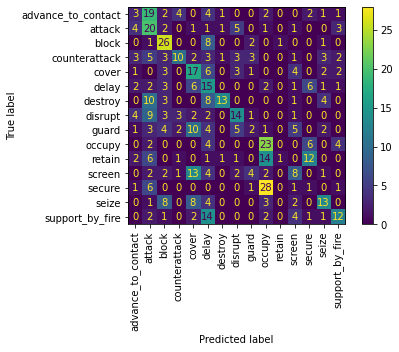

In [269]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["advance_to_contact",
                                                            "attack",
                                                            "block",
                                                            "counterattack",
                                                            "cover",
                                                            "delay",
                                                            "destroy",
                                                            "disrupt",
                                                            "guard",
                                                            "occupy",
                                                            "retain",
                                                            "screen",
                                                            "secure",
                                                            "seize",
                                                            "support_by_fire"])

disp.plot(xticks_rotation= "vertical")